<a href="https://colab.research.google.com/github/askmuhsin/Session_5_assignment/blob/main/Experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target:
* Analysis from last experiment, lead us to look into the data and how to improve the augmentations.
* in this experiment we are trying with RandomErasing of few pixels. (The reason explained in background section of README)
  * `transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0)`
  * the probability of applying this transorm is 50% 
  * this transform when applied would cover an area of 2% to 15% of the image.
  * this transform would be of aspect ration ranging from a distribution of 0.3 to 3.3
# Results:
* Parameters: 9,958
* Best Training Accuracy: 98.84% (EPOCH 15)
* Best Test Accuracy: 99.46% (EPOCH 14)

# Analysis:
  * This model is able to rectify some of the mistakes done by previous models. 
  * The augmentation seems to have helped.
  * But with augmentation the Learning has become solwer, and inorder for it to fit will require more epochs.

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import torchvision

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomAffine(
                                      #     degrees=0,
                                      #     scale=(0.8, 0.9),
                                      #     shear=3
                                      #  ),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


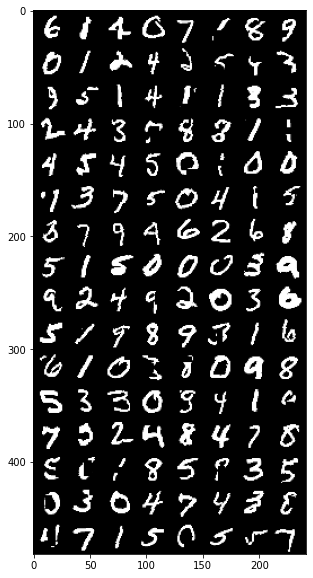

In [5]:
for data, target in train_loader:
  break
grid_img = torchvision.utils.make_grid(data.cpu().detach())
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

# The model
Let's start with the model we first saw

In [6]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=7, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

         # CONVOLUTION BLOCK 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
         # CONVOLUTION BLOCK 6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
         # CONVOLUTION BLOCK 7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        # self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.convblock3(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
           Dropout-4            [-1, 6, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
# from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.2415568083524704 Batch_id=468 Accuracy=81.96: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0884, Accuracy: 9751/10000 (97.51%)

EPOCH: 1


Loss=0.20515769720077515 Batch_id=468 Accuracy=95.28: 100%|██████████| 469/469 [00:18<00:00, 24.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9850/10000 (98.50%)

EPOCH: 2


Loss=0.11739759892225266 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9862/10000 (98.62%)

EPOCH: 3


Loss=0.13717268407344818 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


Loss=0.14549513161182404 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9869/10000 (98.69%)

EPOCH: 5


Loss=0.17260269820690155 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.24443714320659637 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.05132555589079857 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.033074427396059036 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.13476257026195526 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.023862039670348167 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9905/10000 (99.05%)

EPOCH: 11


Loss=0.032275911420583725 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Loss=0.06305675953626633 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.025921126827597618 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:19<00:00, 24.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.023117123171687126 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.07123134285211563 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9922/10000 (99.22%)

EPOCH: 16


Loss=0.04317482188344002 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.0385892279446125 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.10860563069581985 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.04543103277683258 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]



Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)



# Let's Train and test our model

Text(0.5, 1.0, 'Test Accuracy')

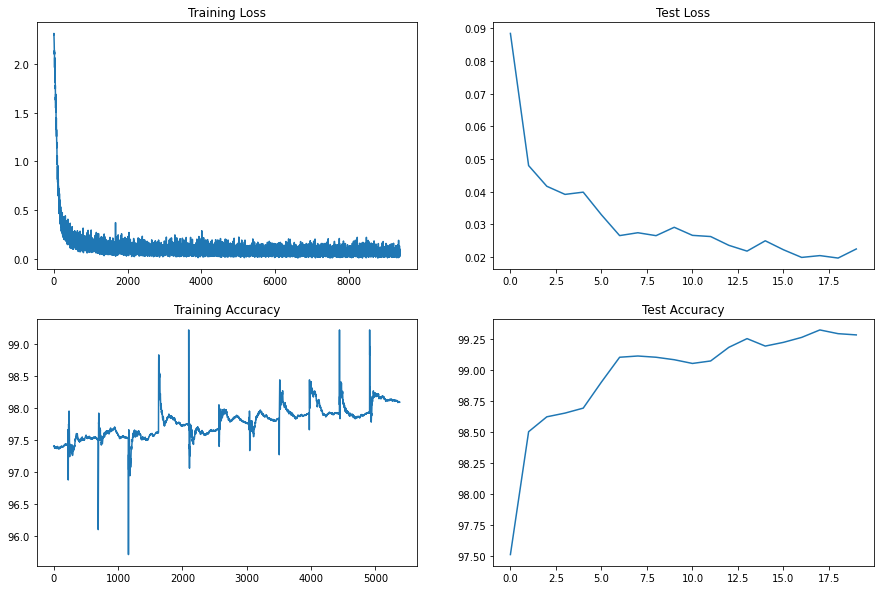

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame()
df['batch_avg_train_acc'] = pd.DataFrame(train_acc).rolling(469).mean().dropna()[::469].reset_index(drop=True)[0]
df['train_acc'] = pd.DataFrame(train_acc)[468::469].reset_index(drop=True)[0]
df['test_acc'] = pd.DataFrame(test_acc)
df['train_losses'] = pd.DataFrame([x.item() for x in train_losses])[468::469].reset_index(drop=True)[0]
df['test_losses'] = pd.DataFrame(test_losses)
df[['test_acc', 'train_acc', 'batch_avg_train_acc', 'train_losses', 'test_losses']]

,test_acc,train_acc,batch_avg_train_acc,train_losses,test_losses
0,97.51,81.961667,63.735056,0.241557,0.088428
1,98.50,95.281667,94.977523,0.205158,0.047961
2,98.62,96.226667,96.102984,0.117398,0.041628
3,98.65,96.596667,96.618282,0.137173,0.039143
4,98.69,96.865000,96.777890,0.145495,0.039827
5,98.90,97.038333,96.797333,0.172603,0.032894
6,99.10,97.251667,97.292774,0.244437,0.026523
7,99.11,97.298333,97.260658,0.051326,0.027402
8,99.10,97.435000,97.356541,0.033074,0.026508
9,99.08,97.501667,97.497012,0.134763,0.029070


In [13]:
max_test_epoch = 13
df[['test_acc', 'train_acc']][max_test_epoch - 3:max_test_epoch + 6]

,test_acc,train_acc
10,99.05,97.538333
11,99.07,97.616667
12,99.18,97.736667
13,99.25,97.678333
14,99.19,97.751667
15,99.22,97.831667
16,99.26,97.918333
17,99.32,97.906667
18,99.29,97.921667


In [14]:
df[:15].max()

batch_avg_train_acc    97.838282
train_acc              97.751667
test_acc               99.250000
train_losses            0.244437
test_losses             0.088428
dtype: float64

In [15]:
df.min()

batch_avg_train_acc    63.735056
train_acc              81.961667
test_acc               97.510000
train_losses            0.023117
test_losses             0.019647
dtype: float64

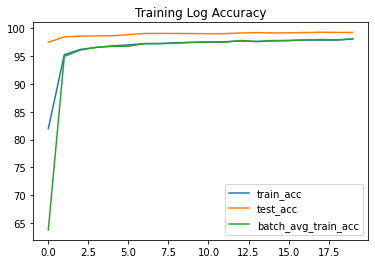

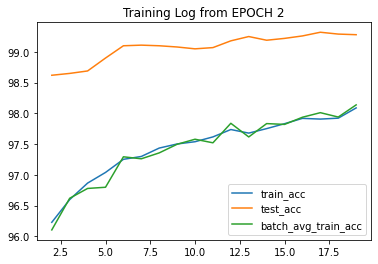

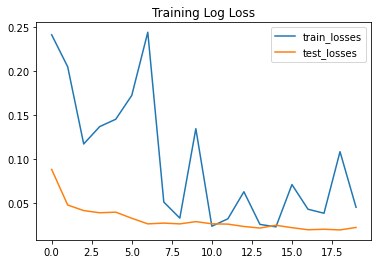

In [16]:
df[['train_acc', 'test_acc', 'batch_avg_train_acc']].plot(title="Training Log Accuracy")
df[['train_acc', 'test_acc', 'batch_avg_train_acc']][2:].plot(title="Training Log from EPOCH 2")
df[['train_losses', 'test_losses']].plot(title="Training Log Loss")

In [17]:
df[15:].var()

batch_avg_train_acc    0.013584
train_acc              0.008858
test_acc               0.001380
train_losses           0.000858
test_losses            0.000002
dtype: float64

In [18]:
## inspect data
model.eval()
test_loss = 0
correct = 0

wrong_correct = []
wrong_predicted = []
wrong_image_data = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        status = pred.eq(target.view_as(pred))
        # correct += status.sum().item()

        mistakes, _ = torch.where(status==False)
        if len(mistakes):
          m_data = data[mistakes]
          m_target = target[mistakes]
          m_output = output[mistakes]
          m_pred = pred[mistakes]
          correct = [x.item() for x in m_target.cpu().detach()]
          predicted = [x.item() for x in m_pred.cpu().detach()]
          image_data = [x for x in m_data.cpu().detach()]

          wrong_correct.extend(correct)
          wrong_predicted.extend(predicted)
          wrong_image_data.extend(image_data)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
from collections import Counter
len(wrong_correct), len(wrong_predicted), len(wrong_image_data)

(72, 72, 72)

In [20]:
mskts = pd.DataFrame(Counter(wrong_correct).most_common(), columns=['number', 'number of times prediction error'])
mskts

,number,number of times prediction error
0,7,13
1,4,13
2,5,12
3,9,9
4,6,8
5,8,6
6,0,5
7,2,4
8,3,2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 7 || Mistakenly predicted as [2, 1, 2, 2, 9, 1, 1, 1, 2, 9, 1, 1, 2]


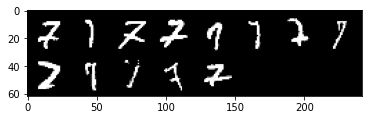

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 4 || Mistakenly predicted as [9, 6, 9, 9, 9, 9, 9, 9, 9, 6, 8, 9, 9]


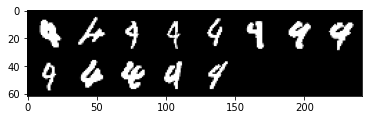

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 5 || Mistakenly predicted as [3, 3, 7, 3, 6, 3, 6, 0, 3, 6, 0, 3]


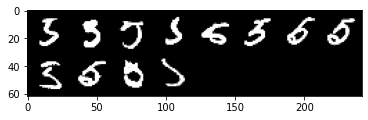

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 9 || Mistakenly predicted as [5, 5, 8, 4, 3, 0, 3, 3, 7]


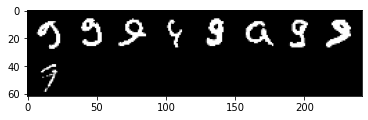

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 6 || Mistakenly predicted as [1, 5, 0, 0, 1, 1, 0, 0]


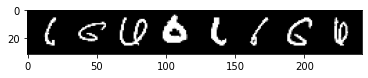

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 8 || Mistakenly predicted as [9, 3, 5, 2, 9, 9]


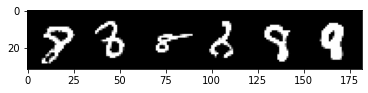

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 0 || Mistakenly predicted as [6, 6, 6, 6, 7]


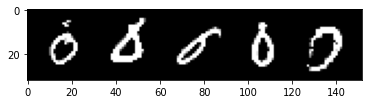

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 2 || Mistakenly predicted as [1, 7, 7, 7]


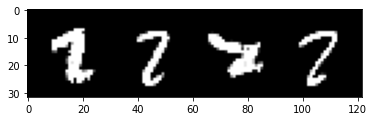


Correct Label -- 3 || Mistakenly predicted as [5, 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


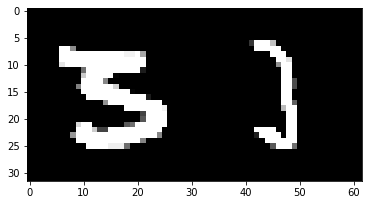

In [21]:
for select_num in mskts['number']:
  # select_num = 9
  img_data_temp = []
  wps = []
  for wc, wp, wi in zip(wrong_correct, wrong_predicted, wrong_image_data):
    if wc == select_num:
      wps.append(wp)
      img_data_temp.append(wi)

  wrong_images_temp = torch.stack(img_data_temp)
  print()
  print(f"Correct Label -- {select_num} || Mistakenly predicted as {wps}")

  grid_img = torchvision.utils.make_grid(wrong_images_temp)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()